This notebook aims at estimating the convergence rate of the fastPLN algorithm with respect to $p$. We will take a sample of size $n= 2000$. 

In [1]:
from fastPLNmodels.utils import build_block_Sigma, C_from_Sigma, sample_PLN, MSE, refined_MSE, MSE
import torch
#from fastPLNmodels.models import IMPS_PLN, log_likelihood, fastPLN, fastPLNPCA, PLNmodel
from fastPLNmodels.models import fastPLN
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time 

device  cuda


In [2]:

import math
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.linalg as TLA
from tqdm import tqdm

from fastPLNmodels.utils import (C_from_Sigma, Poisson_reg, batch_log_P_WgivenY, init_C,
                    init_M, init_Sigma, log_stirling)
from fastPLNmodels.VRA import SAGARAD, SAGRAD, SVRGRAD

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else : 
    device = torch.device('cpu')
    
#device = torch.device('cpu') # think I can't use RTX A5000 right now, will check this later. 
torch.cuda.is_available()

True

In [4]:
%load_ext autoreload

%autoreload 2

In [4]:
def ELBO_PCA(Y, O, covariates, M, S, C, beta):
    '''compute the ELBO with a PCA parametrization'''
    n = Y.shape[0]
    q = C.shape[1]
    # Store some variables that will need to be computed twice
    A = O + torch.mm(covariates, beta) + torch.mm(M, C.T)
    SrondS = torch.multiply(S, S)
    # Next, we add the four terms of the ELBO_PCA
    YA = torch.sum(torch.multiply(Y, A))
    moinsexpAplusSrondSCCT = torch.sum(-torch.exp(A + 1 / 2 *
                       torch.mm(SrondS, torch.multiply(C, C).T)))
    moinslogSrondS = 1 / 2 * torch.sum(torch.log(SrondS))
    MMplusSrondS = torch.sum(-1 / 2 * (torch.multiply(M, M) + torch.multiply(S, S)))
    log_stirlingY = torch.sum(log_stirling(Y))
    return YA + moinsexpAplusSrondSCCT + moinslogSrondS + MMplusSrondS - log_stirlingY + n * q / 2




class fastPLNPCA():
    def __init__(self, q):
        '''Define some usefuls lists and variables for the object. A deeper initalization is done
        in the init_data() method, once the dataset is available.
        Args:
            q: int. The dimension of the latent space.
        Returns:
            A fastPLNPCA object
        '''
        self.old_loss = 1
        self.q = q
        # Lists to store some stats
        self.fitted = False
        self.window = 3
        self.MSE_Sigma_list = list()
        self.MSE_beta_list = list() 

    def init_data(self, Y, O, covariates, good_init):
        '''Initialize the parameters with the right shape given the data.

        Args:
            Y: pd.DataFrame of size (n, p). The counts
            O: pd.DataFrame of size (n,p). the offset
            covariates: pd.DataFrame of size (n,p)
            good_init: bool. If True a good initialization (not random)
                will be performed. Takes some time.
        Returns:
            None but initialize some useful data.'''
        # Lists to store some stats.
        self.ELBO_list = list()
        self.running_times = list()
        self.deltas = [1] * self.window
        self.normalized_ELBOs = list()

        if self.fitted == False:
            self.Y = torch.from_numpy(Y.values).to(device)
            self.O = torch.from_numpy(O.values).to(device)
            self.covariates = torch.from_numpy(covariates.values).to(device)
            self.n, self.p = self.Y.shape
            self.d = self.covariates.shape[1]
            print('Initialization ...')
            # If a good initialization is wanted.
            if good_init:
                poiss_reg = Poisson_reg()
                poiss_reg.fit(self.Y, self.O, self.covariates)
                # Model parameter
                self.beta = torch.clone(poiss_reg.beta.detach()).to(device)
                self.C = init_C(
                    self.Y,
                    self.O,
                    self.covariates,
                    self.beta,
                    self.q).to(device)
                # Variational parameter
                self.M = init_M(
                    self.Y,
                    self.O,
                    self.covariates,
                    self.beta,
                    self.C,
                    300,
                    0.1)
            # Else, random initalization. Faster but worst.
            else:
                self.C = torch.randn((self.p, self.q)).to(device)
                self.beta = torch.randn((self.d, self.p)).to(device)
                self.M = torch.randn((self.n, self.q)).to(device)
            print('Initialization finished')
            # Can't do any further initialization
            self.S = torch.randn((self.n, self.q)).to(device)
            # Set some gradients for optimization
            self.beta.requires_grad_(True)
            self.M.requires_grad_(True)
            self.S.requires_grad_(True)
            self.C.requires_grad_(True)

    def compute_ELBO_PCA(self):
        '''Compute the ELBO of the PCA parametrisation with the parameter of the model.'''
        return ELBO_PCA(self.Y, self.O, self.covariates,
                        self.M, self.S, self.C, self.beta)

    def fit(self, Y, O, covariates, N_iter_max=5000, lr=0.1, optimizer=torch.optim.Rprop,
            tol=1e-3, good_init=True, verbose=False):
        '''Main function of the class. Infer the best parameter C and beta given the data.

        Args:
            Y: pd.DataFrame of size (n, p). The counts.
            O: pd.DataFrame of size (n,p). The offset.
            covariates: pd.DataFrame of size (n,p).
            N_iter_max: int, optional. The maximum number of iteration. (Default is 5000).
            lr: positive float, optional. The learning rate of the optimizer. Default is 0.1.
            optimizer: objects that inherits from torch.optim, optional. The optimize wanted.
                Default is torch.optim.Rprop.
            tol: non negative float. Criterion for the model. The algorithm will
                stop if the ELBO has not improved more than tol(Default is 1e-3).
            good_init: Bool, optional. If True, will do a good initialization. Takes some time.
                Default is True.
            verbose: Bool, optional. If True, will print some stats during the fitting. Default is
                False.
        Returns:
            None but update the parameter C and beta of the object.
        '''
        self.max_Sigma = []
        self.t0 = time.time()
        # initialize the data
        self.init_data(Y, O, covariates, good_init)
        self.optimizer = optimizer([self.beta, self.C, self.M, self.S], lr=lr)
        stop_condition = False
        i = 0
        delta = 1
        while i < N_iter_max and stop_condition == False:
            self.optimizer.zero_grad()
            loss = -self.compute_ELBO_PCA()
            loss.backward()
            self.optimizer.step()
            # Keep records
            self.normalized_ELBOs.append(-1 / self.n * loss.item())
            # Criterion
            if i > self.window - 1:
                delta = abs(
                    self.normalized_ELBOs[-1] - self.normalized_ELBOs[-1 - self.window])
                self.deltas.append(delta)
            # Condition to see if we have reached the tolerance threshold
            if abs(delta) < tol:
                stop_condition = True
            # Print some stats if we want to
            if i % 100 == 0 and verbose:
                print('Iteration number: ', i)
                print('-------UPDATE-------')
                print('Delta : ', delta)
                print('max : ', torch.max(self.get_Sigma()))
            #self.MSE_Sigma_list.append(refined_MSE(self.get_Sigma().cpu() - Sigma_sampling).item())
            #self.MSE_beta_list.append(MSE(self.get_beta().cpu() - true_beta.cpu()).item())
            # Keep track of the time
            self.running_times.append(time.time() - self.t0)
            self.max_Sigma.append(torch.max(self.get_Sigma()).item())
            i += 1
        if stop_condition:
            print('Tolerance {} reached in {} iterations'.format(tol, i))
        else:
            print('Maximum number of iterations reached : ',
                  N_iter_max, 'last delta = ', delta)
        self.fitted = True

    def gradPCA_beta(self):
        '''Compute the gradient of the ELBO with respect to beta. Sanity check'''
        matC = self.C
        CrondC = torch.multiply(matC, matC)
        SrondS = torch.multiply(self.S, self.S)
        first_term = torch.mm(self.covariates.T, self.Y)
        second_term = -1 / 2 * torch.mm(
            self.covariates.T,
            torch.exp(self.O + torch.mm(
                self.covariates,
                self.beta
            )
                + torch.mm(self.M, matC.T) + 1 / 2 * torch.mm(SrondS, CrondC.T))
        )
        return first_term + second_term

    def gradPCA_M(self):
        '''Compute the gradient of the ELBO with respect to M. Sanity check'''
        CrondC = torch.multiply(self.C, self.C)
        SrondS = torch.multiply(self.S, self.S)
        A = self.O + torch.mm(self.covariates, self.beta) + \
            torch.mm(self.M, self.C.T)
        first = torch.mm(self.Y, self.C)
        second = -1 / 2 * \
            torch.mm(torch.exp(A + 1 / 2 * torch.mm(SrondS, CrondC.T)), self.C)
        third = -self.M
        return first + second + third

    def gradPCA_S(self):
        '''Compute the gradient of the ELBO with respect to S. Sanity check'''
        matC = self.C
        CrondC = torch.multiply(matC, matC)
        SrondS = torch.multiply(self.S, self.S)
        A = self.O + torch.mm(self.covariates, self.beta) + \
            torch.mm(self.M, matC.T)
        first = -1 / 2 * \
            torch.multiply(
                self.S,
                torch.mm(
                    torch.exp(
                        A +
                        1 /
                        2 *
                        torch.mm(
                            SrondS,
                            CrondC.T)),
                    CrondC))
        second = torch.div(1, self.S)
        third = -self.S
        return first + second + third

    def gradPCA_C(self):
        '''Compute the gradient of the ELBO with respect to C. Sanity check'''
        matC = self.C
        CrondC = torch.multiply(matC, matC)
        SrondS = torch.multiply(self.S, self.S)
        first = torch.mm(self.Y.T, self.M)
        A = self.O + torch.mm(self.covariates, self.beta) + \
            torch.mm(self.M, matC.T)
        exp = torch.exp(A + 1 / 2 * torch.mm(SrondS, CrondC.T))
        second = -1 / 2 * torch.mm(exp.T, self.M) - 1 / \
            2 * torch.multiply(matC, torch.mm(exp.T, SrondS))
        return first + second

    def show(self, name_doss='fastPLNPCA_graphic', save=False):
        '''Display some useful stats of the model.

        args :
            'name_doss': str, optional. The name of the file the graphic will be saved to.
                Default is 'fastPLNPCA_graphic'.
            'save': Bool, optional. If True, the graphic will be saved. If false, won't be saved.

        returns :
                None but displays the figure. It can also save the figure if save = True.
        '''
        fig, ax = plt.subplots(3, 1, figsize=(10, 8))
        abscisse = self.running_times
        plt.subplots_adjust(hspace=0.4)
        length = len(self.running_times)
        # Plot the negative ELBO
        ax[0].plot(abscisse[int(length/4):], - np.array(self.normalized_ELBOs)
                   [int(length/4):], label='Negative ELBO')
        ax[0].legend()
        ax[0].set_yscale('log')
        ax[0].set_title('Negative ELBO')
        ax[0].set_ylabel('Negative ELBO')
        ax[0].set_xlabel('Seconds')

        # Plot the criteria of the algorithm.
        ax[1].plot(abscisse[self.window+int(length/4):],
                   self.deltas[self.window+int(length/4):],
                   label='Deltas')
        ax[1].set_title('Increments')
        ax[1].set_yscale('log')
        ax[1].legend()
        ax[2].plot(np.arange(len(self.max_Sigma)), self.max_Sigma, label = 'Max sigma')
        ax[2].legend()
        
        '''
        ax[3].plot(abscisse, self.MSE_Sigma_list, label = 'MSE Sigma')
        
        ax[3].set_yscale('log')
        ax[4].plot(abscisse, self.MSE_beta_list, label = 'MSE beta')
        ax[4].set_yscale('log')
        ax[3].legend()
        ax[4].legend()
        '''
        if save:
            plt.savefig(name_doss)
        plt.show()
        if self.p >400: 
            print('The heatmap only displays Sigma[:400,:400]') 
            sns.heatmap(self.get_Sigma()[:400,:400].cpu().detach())
        else: 
            sns.heatmap(self.get_Sigma().cpu().detach())
        plt.show()

    def __str__(self):
        '''Show the stats of the model and Sigma'''
        print('Last ELBO :', self.normalized_ELBOs[-1])
        print('Dimension of the latent space :', self.q)
        self.show()
        return ''

    def get_Sigma(self):
        '''Return the parameter Sigma of the model, that is CC^T'''
        return (self.C @ (self.C.T)).detach()

    def get_C(self):
        '''Getter for C.'''
        return self.C.detach()

    def get_beta(self):
        '''Getter for beta'''
        return self.beta.detach()


In [6]:
d = 1
n = 1000;  p = 50
q = 5

In [7]:
#torch.manual_seed(0)
Sigma_sampling = 1*torch.from_numpy(build_block_Sigma(p,q))/8 #+ 0.5*torch.eye(p)
#true_C = torch.from_numpy(C_from_Sigma(Sigma_sampling, q))
#true_Sigma_sampling = true_C@(true_C.T)
Sigma_sampling.to(device)
true_beta =torch.randn((d, p), device = device )*0.75

covariates = torch.randn((n,d), device = device)/1
O =  1+torch.zeros((n,p), device = device)
Y, Z,_  = sample_PLN(Sigma_sampling,true_beta, O, covariates)

In [99]:
torch.max(Y)

tensor(927., device='cuda:0')

In [100]:
Y = pd.DataFrame(Y.cpu().numpy())
covariates = pd.DataFrame(covariates.cpu().numpy())
O = pd.DataFrame(O.cpu().numpy())

<AxesSubplot:>

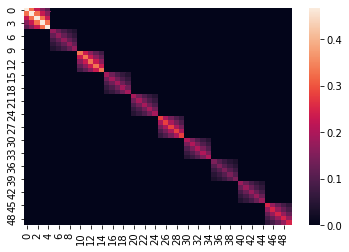

In [101]:
sns.heatmap(Sigma_sampling[:400,:400])

device  cuda
Initialization ...
nb iteration to find the mode:  216
Initialization finished
Last delta: 0.05777788183104349,  reached in 25 iterations
Last ELBO : 104.88108055646799


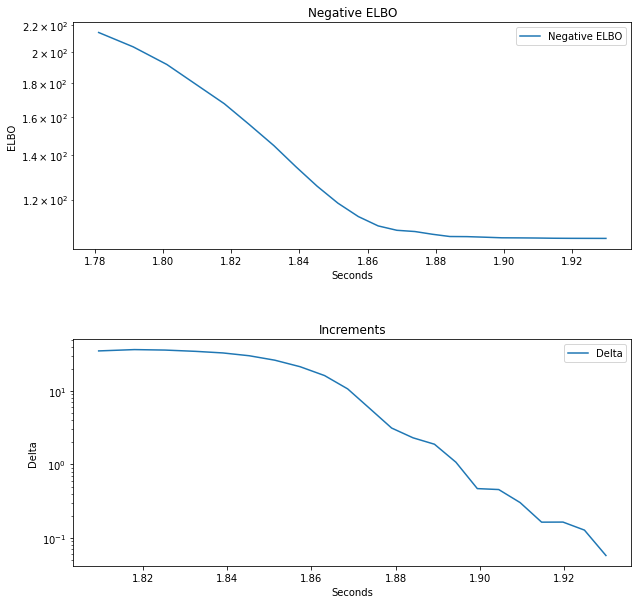

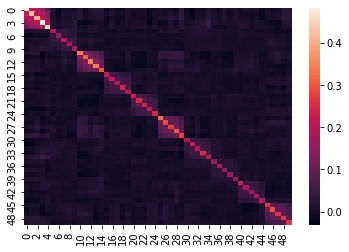

In [111]:
fast = fastPLN()
fast.fit(Y,O,covariates)
print(fast)

In [106]:
fastpca = fastPLNPCA(p)
%time fastpca.fit(Y,O,covariates, good_init = False, verbose = True, lr = 0.01, N_iter_max = 15000, tol = 1e-4)

Initialization ...
Initialization finished
Iteration number:  0
-------UPDATE-------
Delta :  1
max :  tensor(83.5203, device='cuda:0')
Iteration number:  100
-------UPDATE-------
Delta :  0.19586275996744007
max :  tensor(2.8843, device='cuda:0')
Iteration number:  200
-------UPDATE-------
Delta :  0.03291387553984748
max :  tensor(0.5023, device='cuda:0')
Iteration number:  300
-------UPDATE-------
Delta :  0.003899683067814408
max :  tensor(0.4461, device='cuda:0')
Iteration number:  400
-------UPDATE-------
Delta :  0.0017115071764379763
max :  tensor(0.4489, device='cuda:0')
Iteration number:  500
-------UPDATE-------
Delta :  0.0003243601905325022
max :  tensor(0.4480, device='cuda:0')
Iteration number:  600
-------UPDATE-------
Delta :  0.0001133551523935239
max :  tensor(0.4476, device='cuda:0')
Tolerance 0.0001 reached in 626 iterations
CPU times: user 4.38 s, sys: 23.1 ms, total: 4.4 s
Wall time: 4.37 s


Last ELBO : -105.38839623728465
Dimension of the latent space : 10


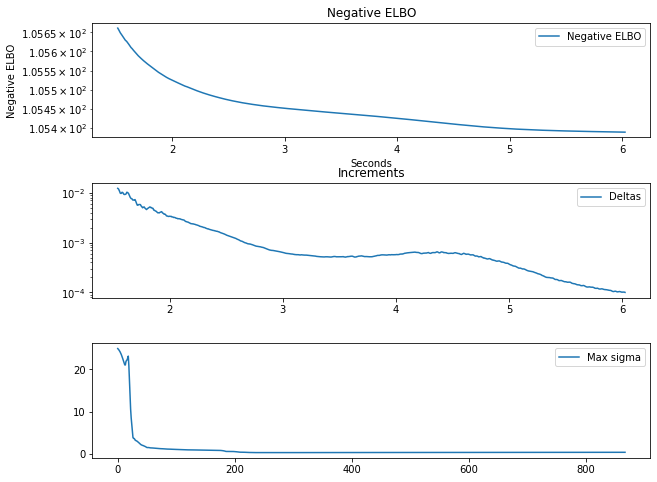

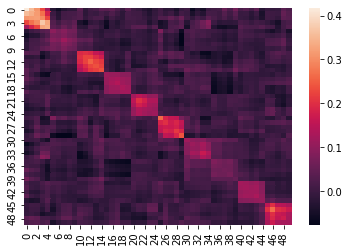

In [105]:
print(fastpca)

In [51]:
torch.max(Sigma_sampling)

tensor(2.1143)

ns : [  100  1858  3617  5376  7135  8894 10652 12411 14170 15929 17688 19447
 21205 22964 24723 26482 28241 30000]
n :  100
Initialization ...
Initialization finished
Iteration number:  0
-------UPDATE-------
Delta :  0
Iteration number:  10
-------UPDATE-------
Delta :  1094.8655511772304
Iteration number:  20
-------UPDATE-------
Delta :  2063.0472300391966
Iteration number:  30
-------UPDATE-------
Delta :  11.232127846325739
Iteration number:  40
-------UPDATE-------
Delta :  0.624258019744957
Iteration number:  50
-------UPDATE-------
Delta :  0.1776652497123905
Maximum number of iterations reached :  60 last delta =  0.036071228960054214
Fast
Last ELBO : 1661.6193909456745


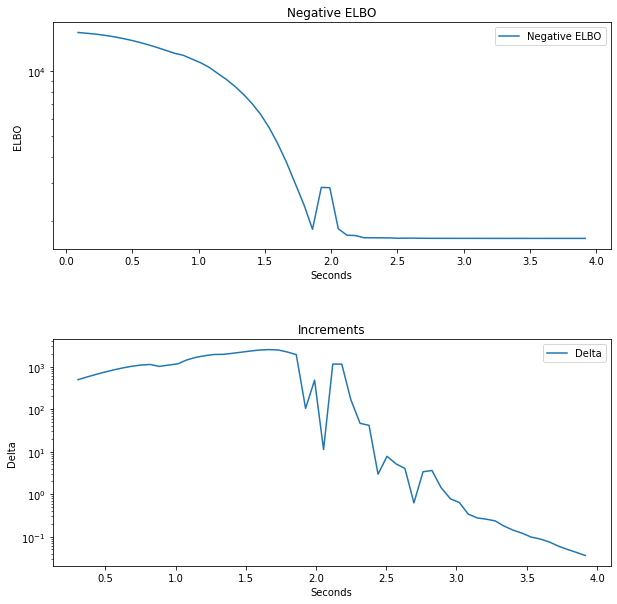

The heatmap only displays Sigma[:400,:400]


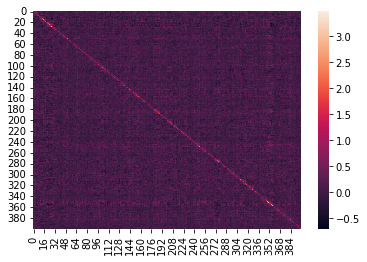


Initialization ...
Initialization finished
Maximum number of iterations reached :  15000 last delta =  6.17917112322175e-05
Fastpca
Last ELBO : -2461.7378272624082
Dimension of the latent space : 10


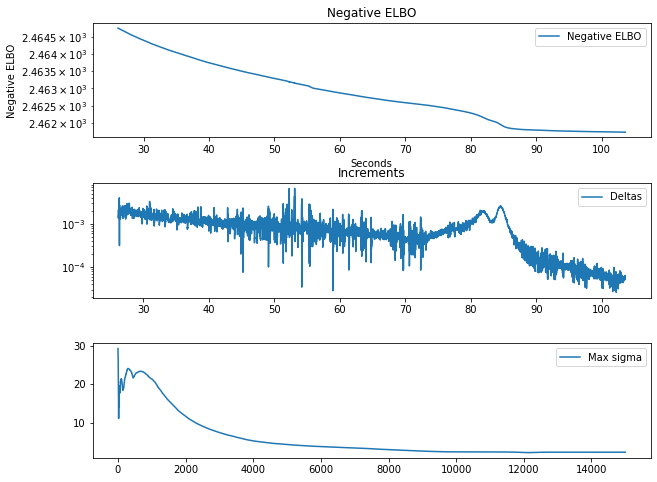

The heatmap only displays Sigma[:400,:400]


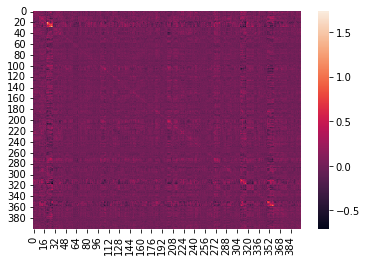

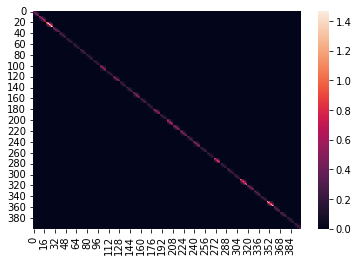

n :  1858
Initialization ...
Initialization finished
Iteration number:  0
-------UPDATE-------
Delta :  0
Iteration number:  10
-------UPDATE-------
Delta :  954.0162525343803
Iteration number:  20
-------UPDATE-------
Delta :  1632.5050417984485
Iteration number:  30
-------UPDATE-------
Delta :  529.4119716594787
Iteration number:  40
-------UPDATE-------
Delta :  2.841650059264339
Iteration number:  50
-------UPDATE-------
Delta :  0.0886512367483192
Maximum number of iterations reached :  60 last delta =  0.006200444684964168
Fast
Last ELBO : 2194.612833837003


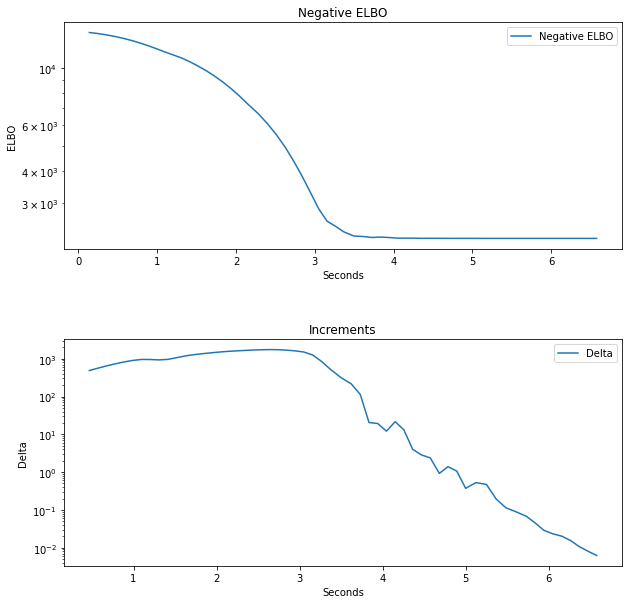

The heatmap only displays Sigma[:400,:400]


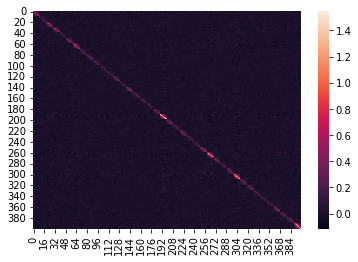


Initialization ...
Initialization finished
Maximum number of iterations reached :  15000 last delta =  0.0010546822522883303
Fastpca
Last ELBO : -3114.8192912212926
Dimension of the latent space : 10


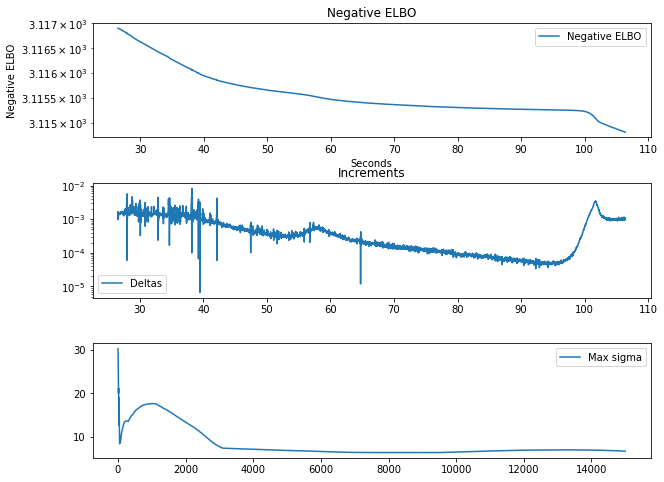

The heatmap only displays Sigma[:400,:400]


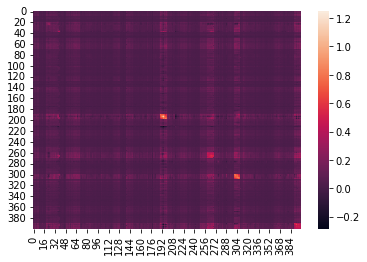

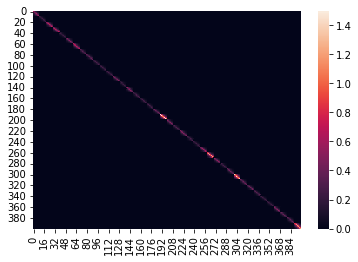

n :  3617
Initialization ...
Initialization finished
Iteration number:  0
-------UPDATE-------
Delta :  0
Iteration number:  10
-------UPDATE-------
Delta :  799.5089462794849
Iteration number:  20
-------UPDATE-------
Delta :  827.8298238634607
Iteration number:  30
-------UPDATE-------
Delta :  62.27900745098532
Iteration number:  40
-------UPDATE-------
Delta :  0.6447273720450539
Iteration number:  50
-------UPDATE-------
Delta :  0.019448480906248733
Maximum number of iterations reached :  60 last delta =  0.0010582859781607112
Fast
Last ELBO : 2195.8108474406486


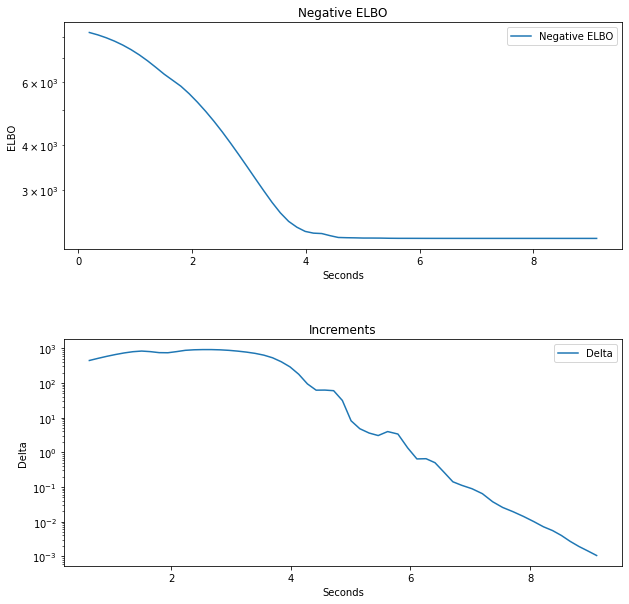

The heatmap only displays Sigma[:400,:400]


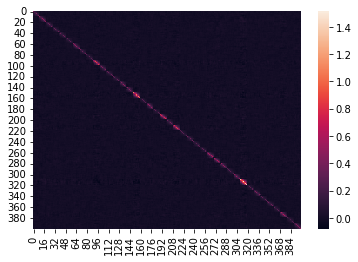


Initialization ...
Initialization finished
Maximum number of iterations reached :  15000 last delta =  6.093699084885884e-06
Fastpca
Last ELBO : -2922.9154641466826
Dimension of the latent space : 10


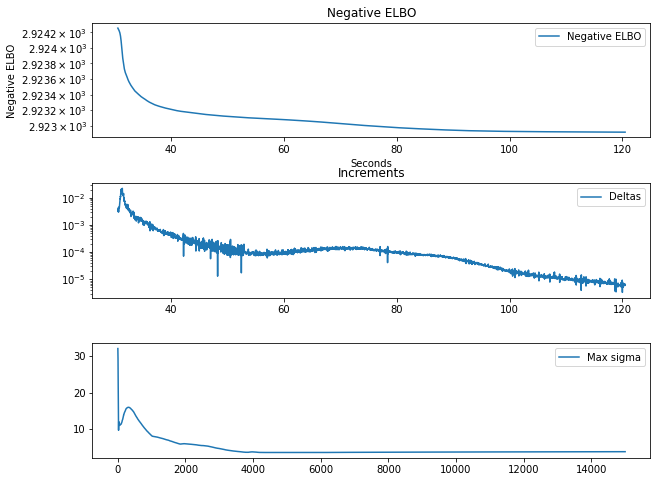

The heatmap only displays Sigma[:400,:400]


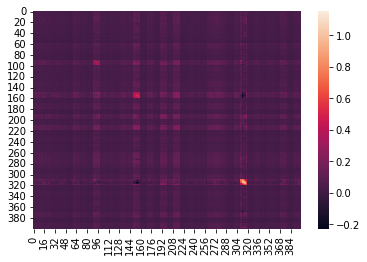

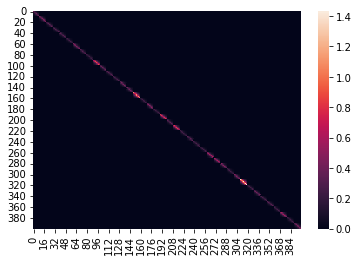

n :  5376
Initialization ...
Initialization finished
Iteration number:  0
-------UPDATE-------
Delta :  0
Iteration number:  10
-------UPDATE-------
Delta :  856.2074558817058
Iteration number:  20
-------UPDATE-------
Delta :  1070.5689671440105
Iteration number:  30
-------UPDATE-------
Delta :  87.68583849697598
Iteration number:  40
-------UPDATE-------
Delta :  1.26053306051017
Iteration number:  50
-------UPDATE-------
Delta :  0.04821478428721093
Maximum number of iterations reached :  60 last delta =  0.00281572088260873
Fast
Last ELBO : 2228.224096096581


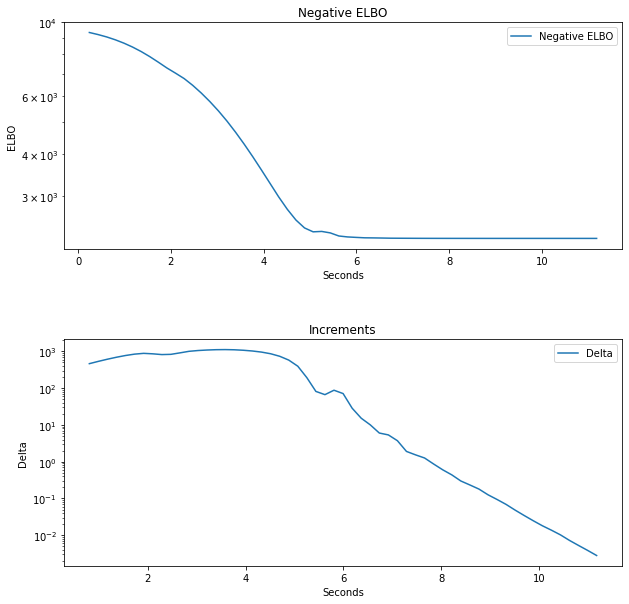

The heatmap only displays Sigma[:400,:400]


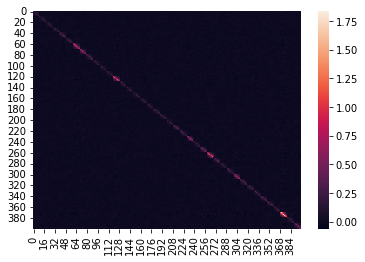


Initialization ...
Initialization finished
Maximum number of iterations reached :  15000 last delta =  2.7485189093567897e-06
Fastpca
Last ELBO : -3150.857667769323
Dimension of the latent space : 10


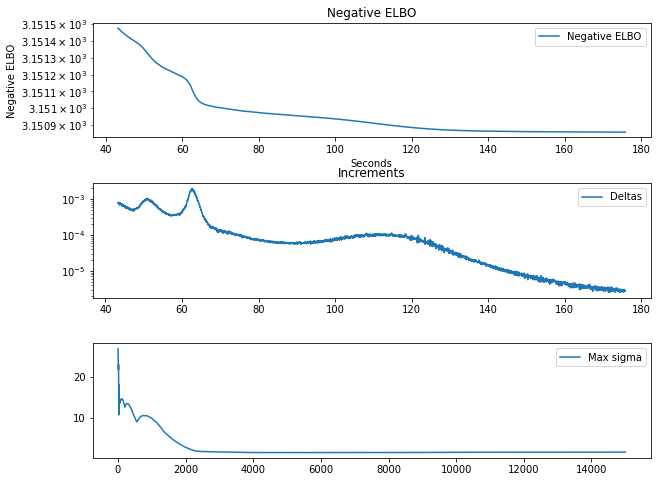

The heatmap only displays Sigma[:400,:400]


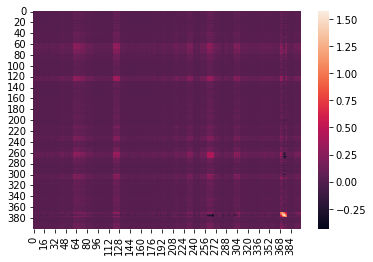

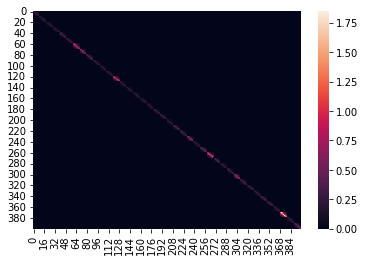

n :  7135
Initialization ...
Initialization finished
Iteration number:  0
-------UPDATE-------
Delta :  0
Iteration number:  10
-------UPDATE-------
Delta :  834.3347883184988
Iteration number:  20
-------UPDATE-------
Delta :  968.6630896106276
Iteration number:  30
-------UPDATE-------
Delta :  61.910835117840634
Iteration number:  40
-------UPDATE-------
Delta :  1.1026589342241095
Iteration number:  50
-------UPDATE-------
Delta :  0.043946673313257634
Maximum number of iterations reached :  60 last delta =  0.0030450522781393374
Fast
Last ELBO : 2210.542476173892


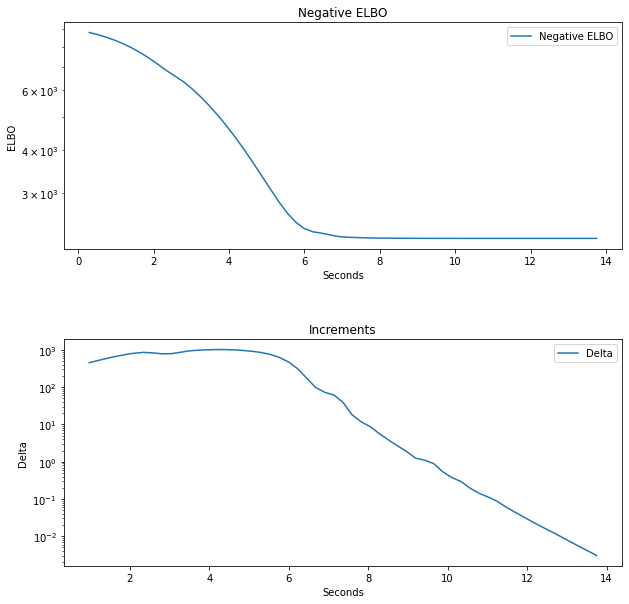

The heatmap only displays Sigma[:400,:400]


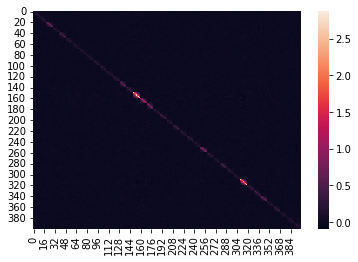


Initialization ...
Initialization finished
Maximum number of iterations reached :  15000 last delta =  5.610595508187544e-07
Fastpca
Last ELBO : -2985.523504786784
Dimension of the latent space : 10


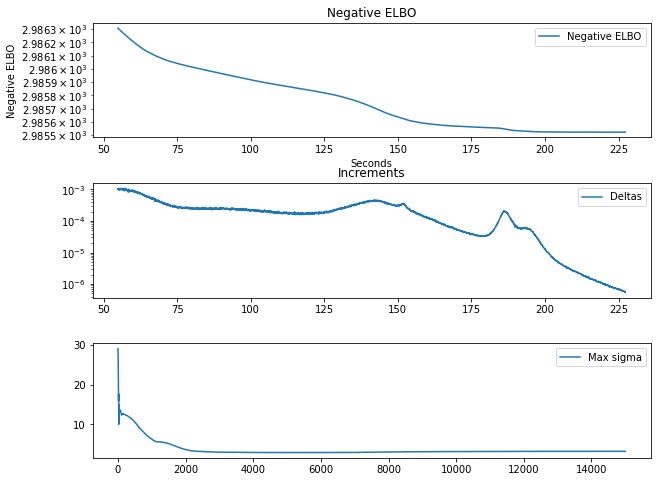

The heatmap only displays Sigma[:400,:400]


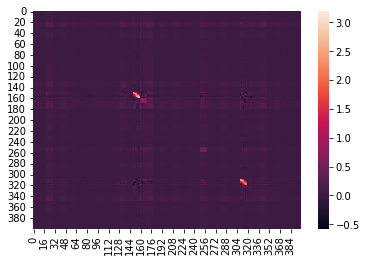

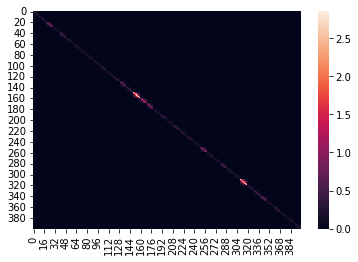

n :  8894
Initialization ...
Initialization finished
Iteration number:  0
-------UPDATE-------
Delta :  0
Iteration number:  10
-------UPDATE-------
Delta :  844.6600938926522
Iteration number:  20
-------UPDATE-------
Delta :  1072.0767143341955
Iteration number:  30
-------UPDATE-------
Delta :  86.78799233015798
Iteration number:  40
-------UPDATE-------
Delta :  1.2313830317398242
Iteration number:  50
-------UPDATE-------
Delta :  0.04629969937786882
Maximum number of iterations reached :  60 last delta =  0.0024772743836365407
Fast
Last ELBO : 2215.904559602401


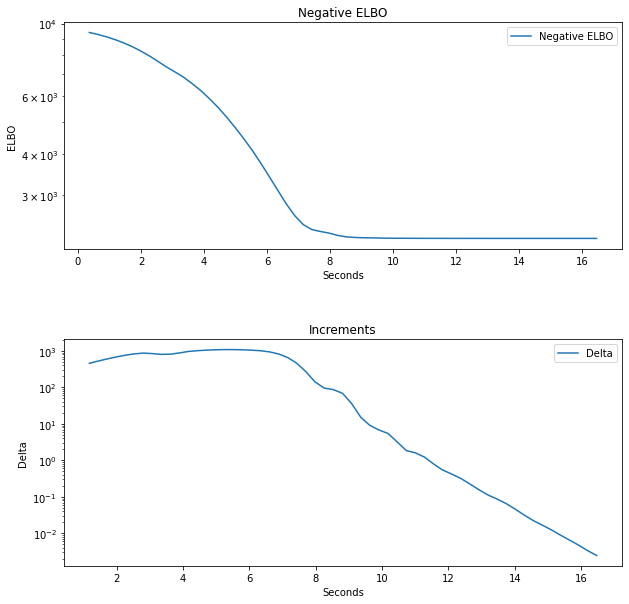

The heatmap only displays Sigma[:400,:400]


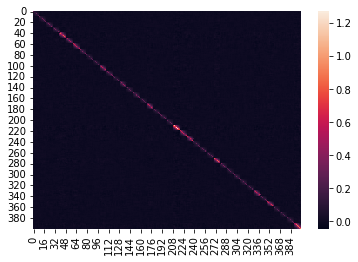


Initialization ...
Initialization finished
Maximum number of iterations reached :  15000 last delta =  2.1473856577358674e-06
Fastpca
Last ELBO : -2975.731928647449
Dimension of the latent space : 10


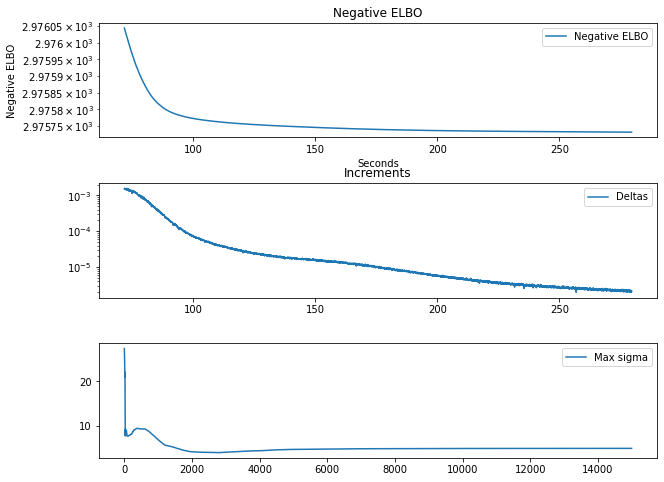

The heatmap only displays Sigma[:400,:400]


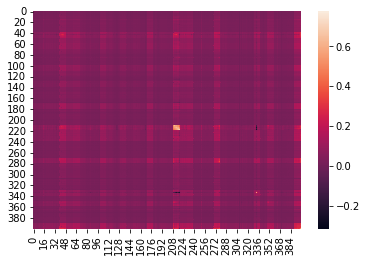

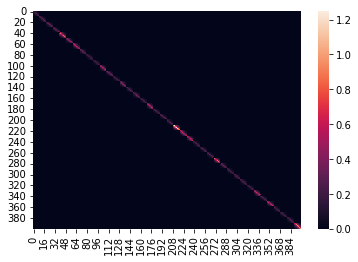

n :  10652
Initialization ...
Initialization finished
Iteration number:  0
-------UPDATE-------
Delta :  0
Iteration number:  10
-------UPDATE-------
Delta :  810.9135845858273
Iteration number:  20
-------UPDATE-------
Delta :  909.1256566992511
Iteration number:  30
-------UPDATE-------
Delta :  60.63406328443989
Iteration number:  40
-------UPDATE-------
Delta :  0.7034321504984291
Iteration number:  50
-------UPDATE-------
Delta :  0.014099193634137919
Maximum number of iterations reached :  60 last delta =  0.0005576503631345986
Fast
Last ELBO : 2233.7745160632076


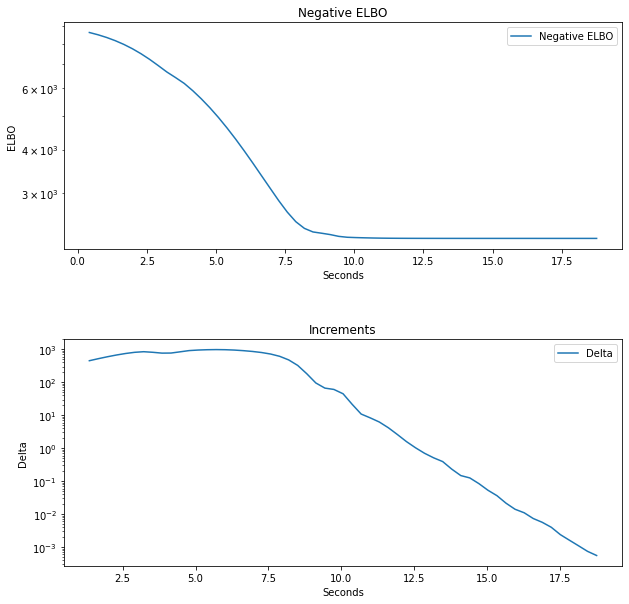

The heatmap only displays Sigma[:400,:400]


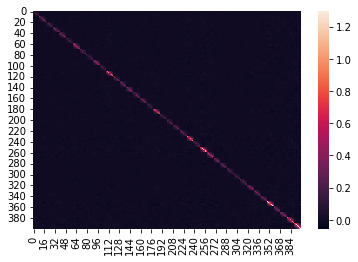


Initialization ...
Initialization finished
Maximum number of iterations reached :  15000 last delta =  7.614926289534196e-08
Fastpca
Last ELBO : -3066.124244059686
Dimension of the latent space : 10


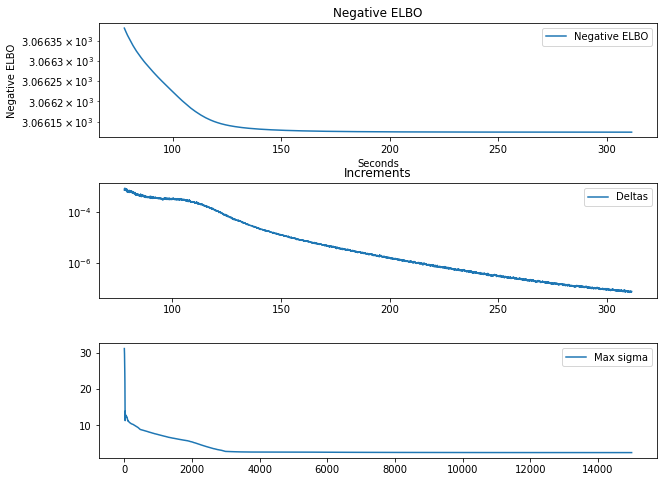

The heatmap only displays Sigma[:400,:400]


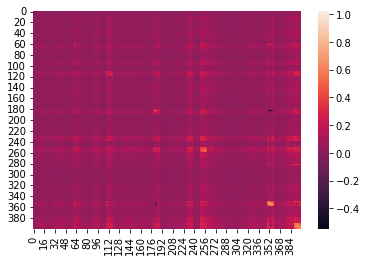

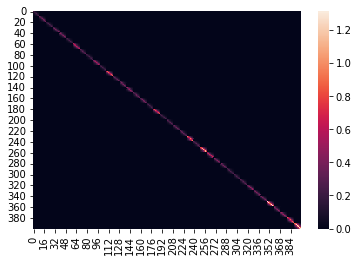

n :  12411
Initialization ...
Initialization finished
Iteration number:  0
-------UPDATE-------
Delta :  0
Iteration number:  10
-------UPDATE-------
Delta :  856.4552585017691
Iteration number:  20
-------UPDATE-------
Delta :  1144.354946160861
Iteration number:  30
-------UPDATE-------
Delta :  18.686230160297782
Iteration number:  40
-------UPDATE-------
Delta :  2.470028313412058
Iteration number:  50
-------UPDATE-------
Delta :  0.08998741443519975
Maximum number of iterations reached :  60 last delta =  0.008419688005233184
Fast
Last ELBO : 2211.9589022160617


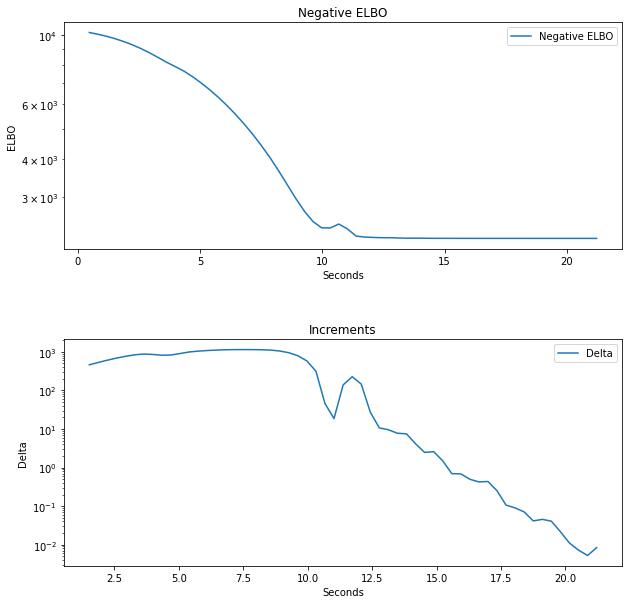

The heatmap only displays Sigma[:400,:400]


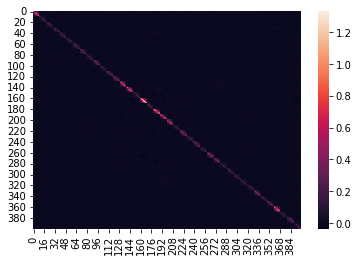


Initialization ...
Initialization finished
Maximum number of iterations reached :  15000 last delta =  7.184376045188401e-07
Fastpca
Last ELBO : -2951.3841655915844
Dimension of the latent space : 10


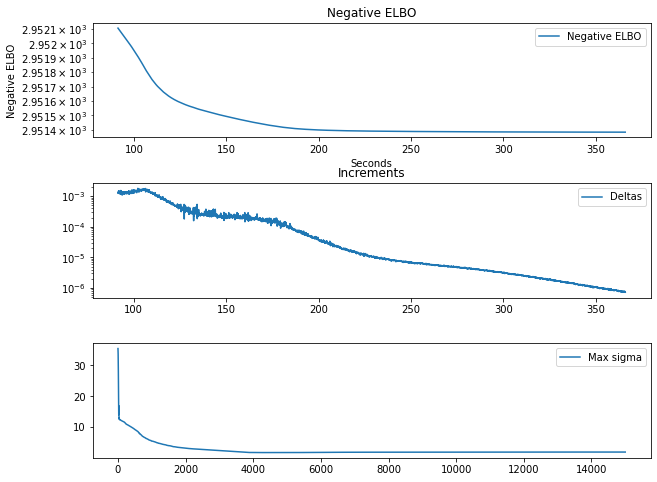

The heatmap only displays Sigma[:400,:400]


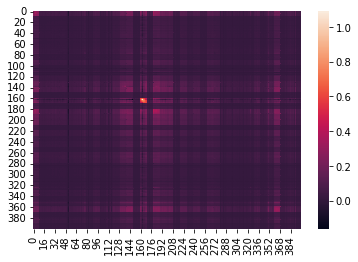

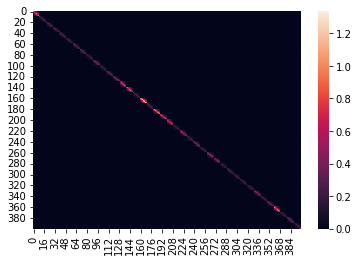

n :  14170
Initialization ...
Initialization finished
Iteration number:  0
-------UPDATE-------
Delta :  0
Iteration number:  10
-------UPDATE-------
Delta :  876.3961480057051
Iteration number:  20
-------UPDATE-------
Delta :  1250.1859439912532
Iteration number:  30
-------UPDATE-------
Delta :  113.51997027939387
Iteration number:  40
-------UPDATE-------
Delta :  1.571591654232634
Iteration number:  50
-------UPDATE-------
Delta :  0.06021103317561938
Maximum number of iterations reached :  60 last delta =  0.003779942718665552
Fast
Last ELBO : 2241.472067705348


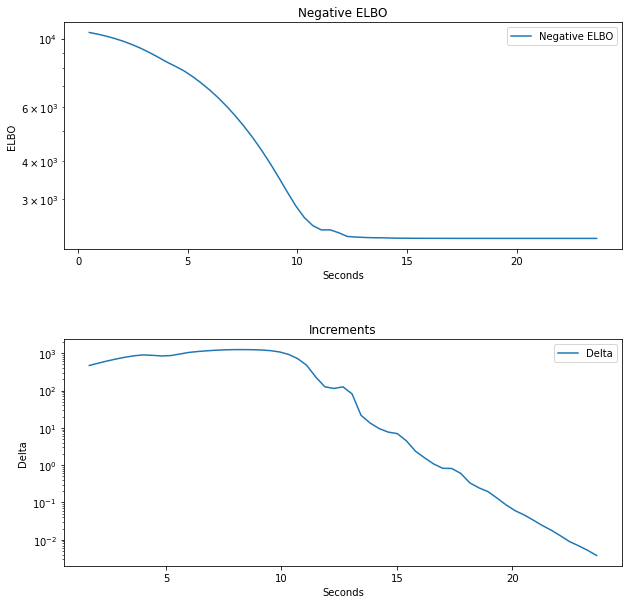

The heatmap only displays Sigma[:400,:400]


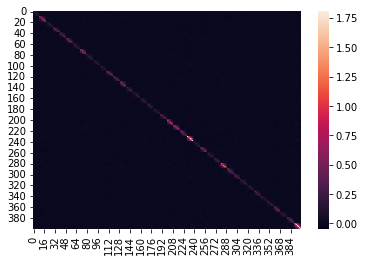


Initialization ...
Initialization finished
Maximum number of iterations reached :  15000 last delta =  3.0389882340386976e-05
Fastpca
Last ELBO : -3149.8609585910954
Dimension of the latent space : 10


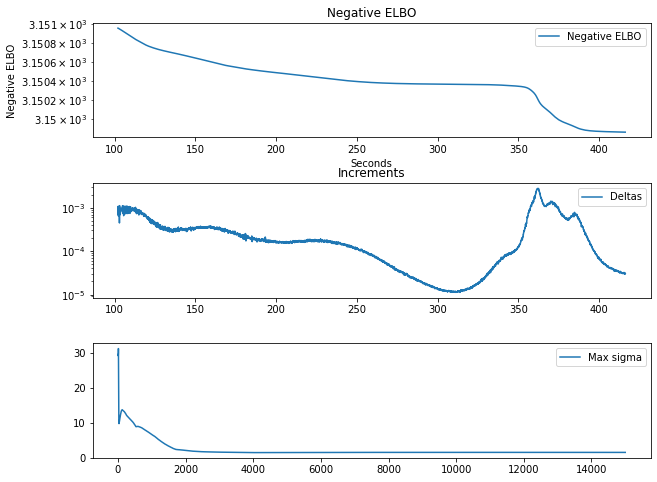

The heatmap only displays Sigma[:400,:400]


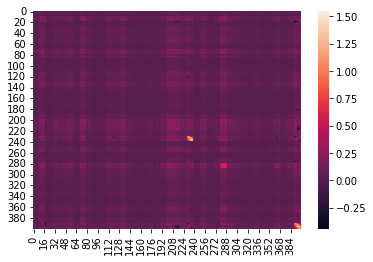

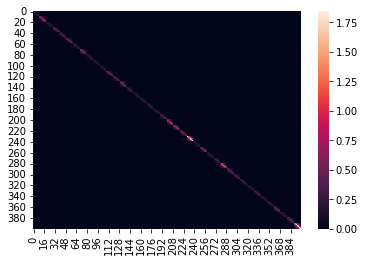

n :  15929
Initialization ...
Initialization finished
Iteration number:  0
-------UPDATE-------
Delta :  0
Iteration number:  10
-------UPDATE-------
Delta :  908.5371770822585
Iteration number:  20
-------UPDATE-------
Delta :  1453.9772801294685
Iteration number:  30
-------UPDATE-------
Delta :  11.355147392425806
Iteration number:  40
-------UPDATE-------
Delta :  4.628806070839801
Iteration number:  50
-------UPDATE-------
Delta :  0.07739484469948366
Maximum number of iterations reached :  60 last delta =  0.004150820826907875
Fast
Last ELBO : 2222.759246991874


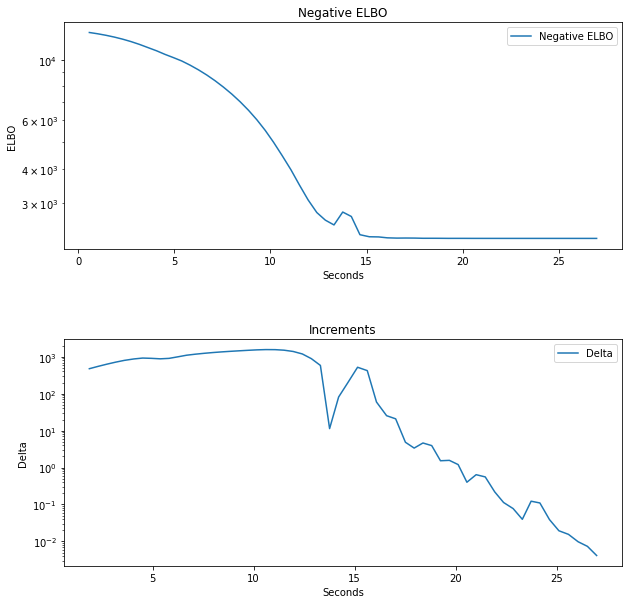

The heatmap only displays Sigma[:400,:400]


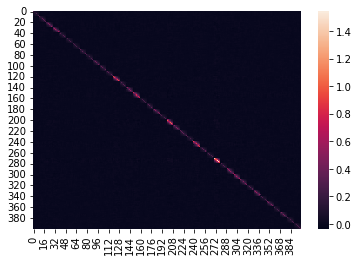


Initialization ...
Initialization finished
Maximum number of iterations reached :  15000 last delta =  2.442901541144238e-05
Fastpca
Last ELBO : -2980.1216985948536
Dimension of the latent space : 10


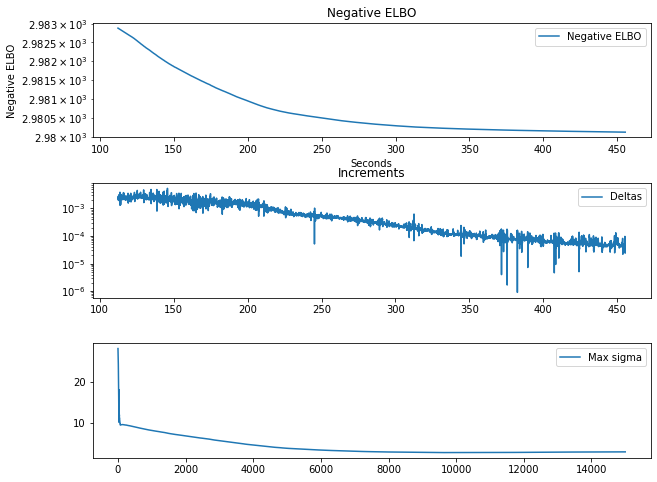

The heatmap only displays Sigma[:400,:400]


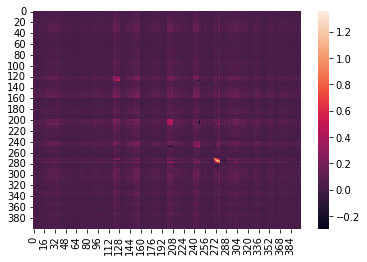

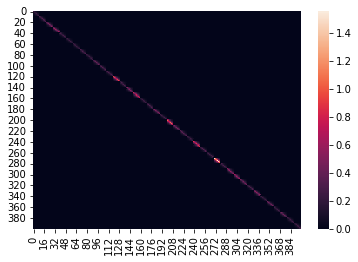

n :  17688
Initialization ...
Initialization finished
Iteration number:  0
-------UPDATE-------
Delta :  0
Iteration number:  10
-------UPDATE-------
Delta :  800.3098294578249
Iteration number:  20
-------UPDATE-------
Delta :  841.4776784662749
Iteration number:  30
-------UPDATE-------
Delta :  66.35979891637135
Iteration number:  40
-------UPDATE-------
Delta :  0.8390116931400371
Iteration number:  50
-------UPDATE-------
Delta :  0.03607959900091373
Maximum number of iterations reached :  60 last delta =  0.0011376826582818467
Fast
Last ELBO : 2211.384032718918


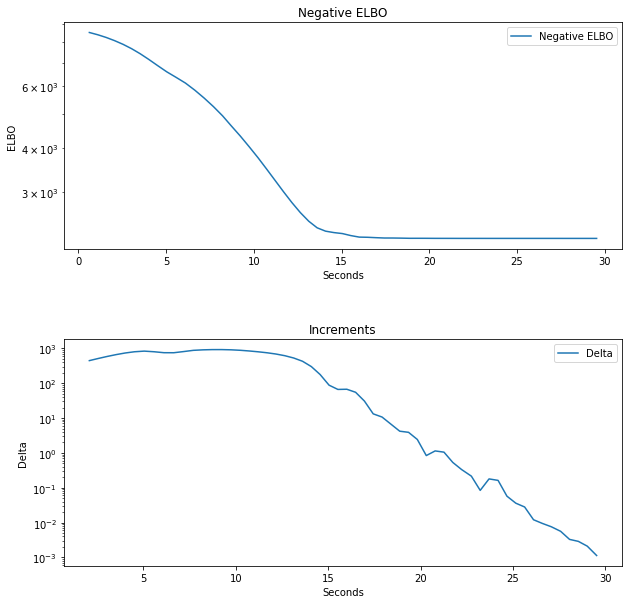

The heatmap only displays Sigma[:400,:400]


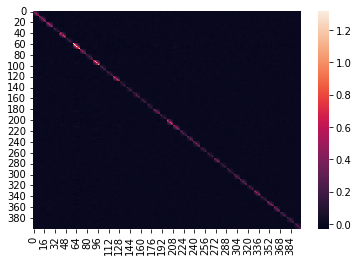


Initialization ...
Initialization finished
Maximum number of iterations reached :  15000 last delta =  9.786162991076708e-10
Fastpca
Last ELBO : -2873.1198693084057
Dimension of the latent space : 10


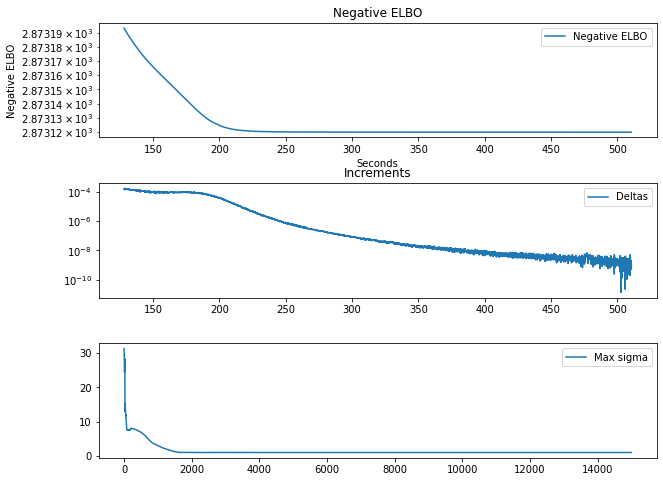

The heatmap only displays Sigma[:400,:400]


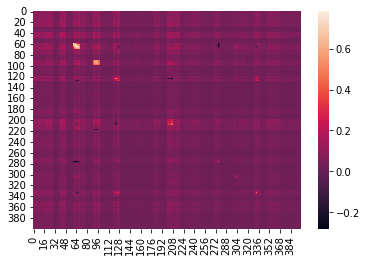

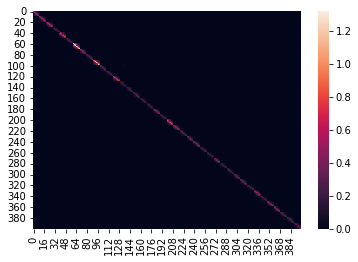

n :  19447
Initialization ...
Initialization finished
Iteration number:  0
-------UPDATE-------
Delta :  0
Iteration number:  10
-------UPDATE-------
Delta :  803.9553984470522
Iteration number:  20
-------UPDATE-------
Delta :  874.4736228278939
Iteration number:  30
-------UPDATE-------
Delta :  55.44444702998362
Iteration number:  40
-------UPDATE-------
Delta :  1.1040976419531034
Iteration number:  50
-------UPDATE-------
Delta :  0.02406479541286899
Maximum number of iterations reached :  60 last delta =  0.0010325993175683834
Fast
Last ELBO : 2225.3688783695115


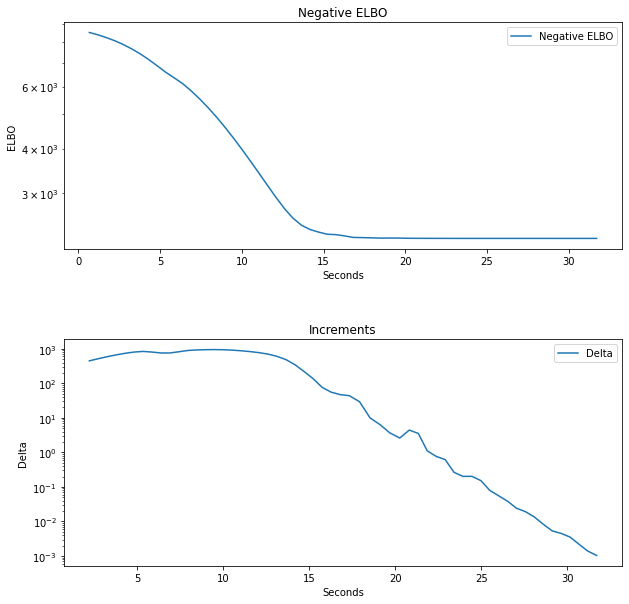

The heatmap only displays Sigma[:400,:400]


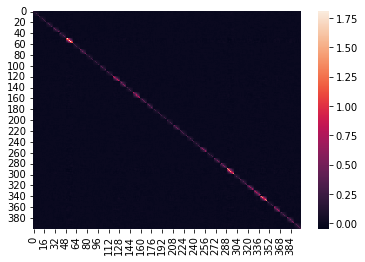


Initialization ...
Initialization finished
Maximum number of iterations reached :  15000 last delta =  3.43472038366599e-07
Fastpca
Last ELBO : -2993.308234993085
Dimension of the latent space : 10


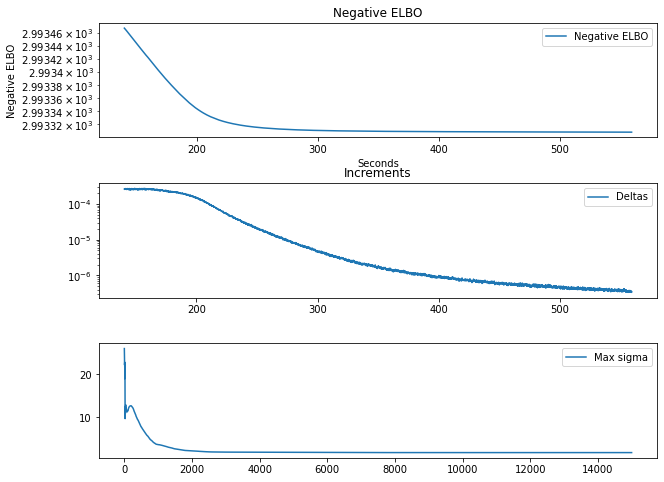

The heatmap only displays Sigma[:400,:400]


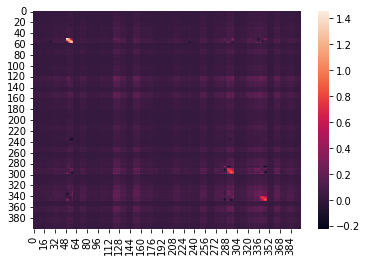

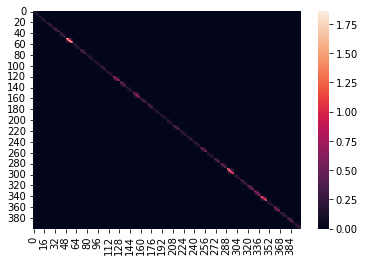

n :  21205
Initialization ...
Initialization finished
Iteration number:  0
-------UPDATE-------
Delta :  0
Iteration number:  10
-------UPDATE-------
Delta :  823.2083767562108
Iteration number:  20
-------UPDATE-------
Delta :  959.450818243979
Iteration number:  30
-------UPDATE-------
Delta :  74.77989977641892
Iteration number:  40
-------UPDATE-------
Delta :  1.115688731870705
Iteration number:  50
-------UPDATE-------
Delta :  0.03095308031379318
Maximum number of iterations reached :  60 last delta =  0.0013988134683131648
Fast
Last ELBO : 2234.391850462585


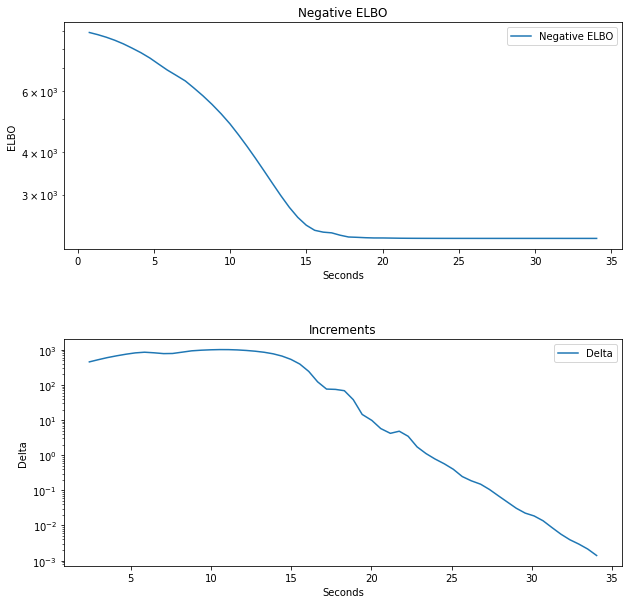

The heatmap only displays Sigma[:400,:400]


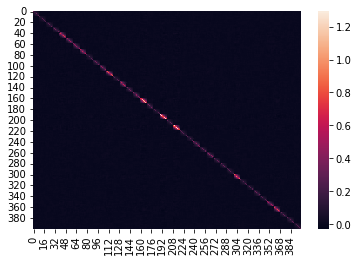


Initialization ...
Initialization finished
Maximum number of iterations reached :  15000 last delta =  2.9823422664776444e-07
Fastpca
Last ELBO : -3055.599312951917
Dimension of the latent space : 10


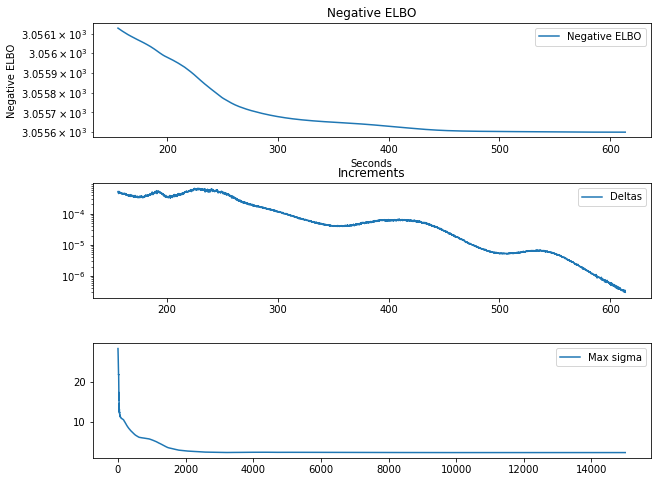

The heatmap only displays Sigma[:400,:400]


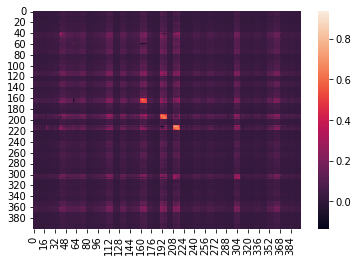

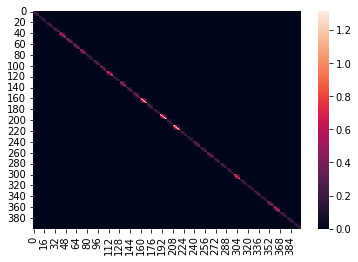

n :  22964
Initialization ...
Initialization finished
Iteration number:  0
-------UPDATE-------
Delta :  0
Iteration number:  10
-------UPDATE-------
Delta :  871.6629062776301
Iteration number:  20
-------UPDATE-------
Delta :  1215.7497036052464
Iteration number:  30
-------UPDATE-------
Delta :  82.44571831678195
Iteration number:  40
-------UPDATE-------
Delta :  1.9496144648760492
Iteration number:  50
-------UPDATE-------
Delta :  0.03154861320990676
Maximum number of iterations reached :  60 last delta =  0.00107014258765048
Fast
Last ELBO : 2243.8941251833776


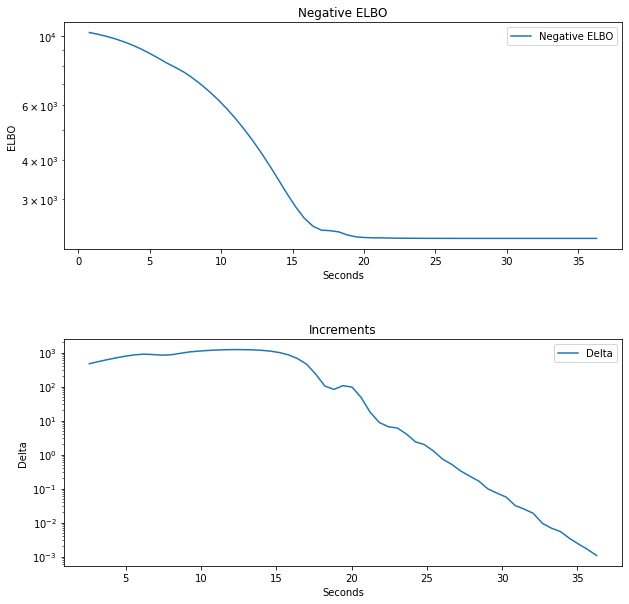

The heatmap only displays Sigma[:400,:400]


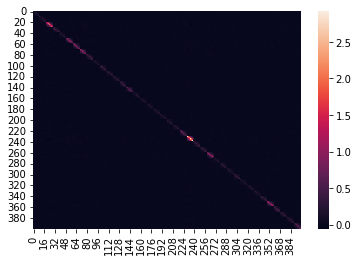


Initialization ...
Initialization finished
Maximum number of iterations reached :  15000 last delta =  4.39767973148264e-08
Fastpca
Last ELBO : -3170.7070359077056
Dimension of the latent space : 10


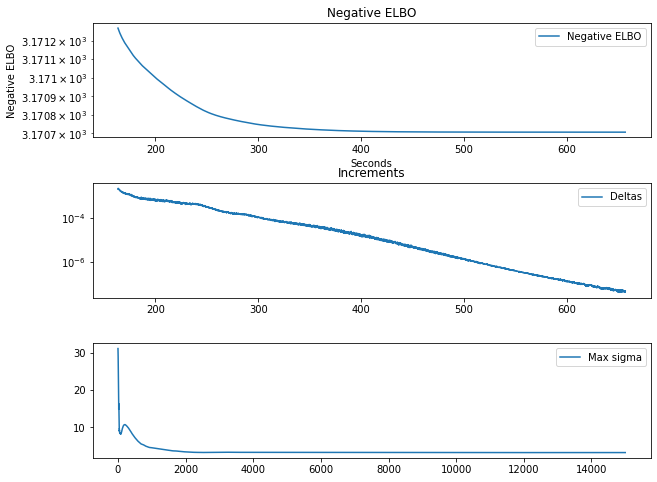

The heatmap only displays Sigma[:400,:400]


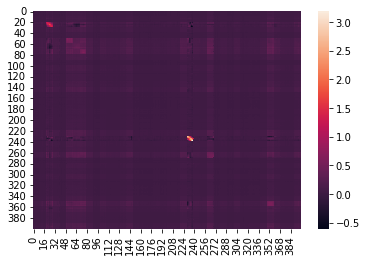

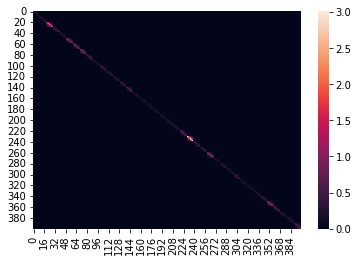

n :  24723
Initialization ...
Initialization finished
Iteration number:  0
-------UPDATE-------
Delta :  0
Iteration number:  10
-------UPDATE-------
Delta :  860.3499238420773
Iteration number:  20
-------UPDATE-------
Delta :  1143.0994746660435
Iteration number:  30
-------UPDATE-------
Delta :  78.97388862805064
Iteration number:  40
-------UPDATE-------
Delta :  1.8849429847646206
Iteration number:  50
-------UPDATE-------
Delta :  0.08201276854970274
Maximum number of iterations reached :  60 last delta =  0.005220298039603222
Fast
Last ELBO : 2199.1815134169287


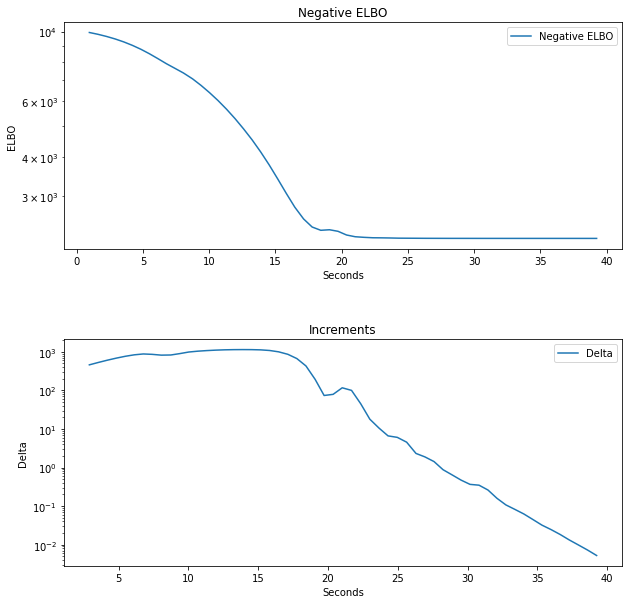

The heatmap only displays Sigma[:400,:400]


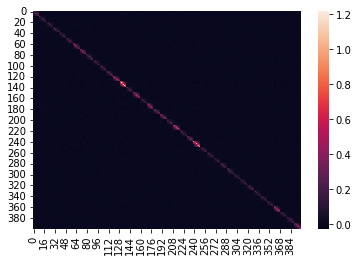


Initialization ...
Initialization finished
Maximum number of iterations reached :  15000 last delta =  2.48899223151966e-05
Fastpca
Last ELBO : -2844.793139011685
Dimension of the latent space : 10


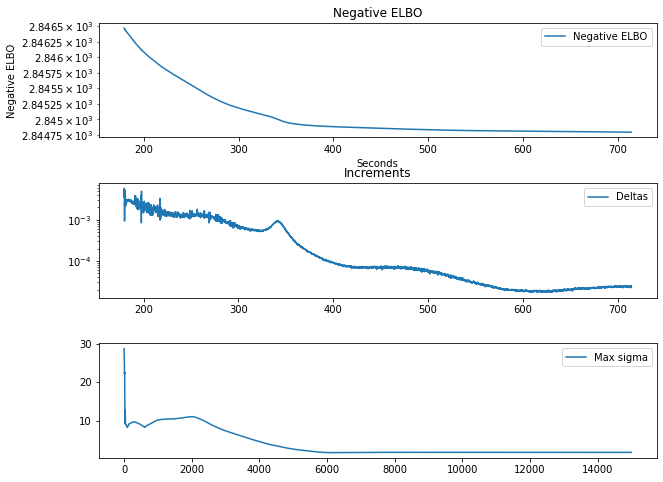

The heatmap only displays Sigma[:400,:400]


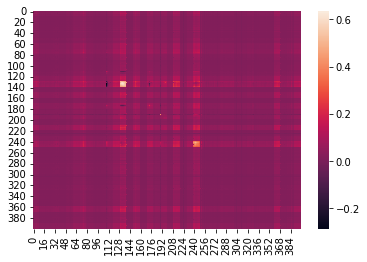

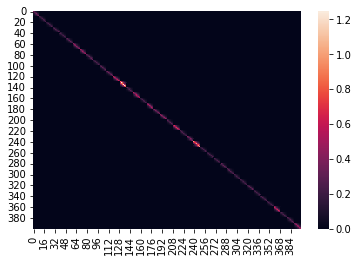

n :  26482
Initialization ...
Initialization finished
Iteration number:  0
-------UPDATE-------
Delta :  0
Iteration number:  10
-------UPDATE-------
Delta :  851.471695586536
Iteration number:  20
-------UPDATE-------
Delta :  1121.4999197718225
Iteration number:  30
-------UPDATE-------
Delta :  72.00372647333188
Iteration number:  40
-------UPDATE-------
Delta :  2.373584452329851
Iteration number:  50
-------UPDATE-------
Delta :  0.03944424908650035
Maximum number of iterations reached :  60 last delta =  0.0012723507006739965
Fast
Last ELBO : 2247.664076607797


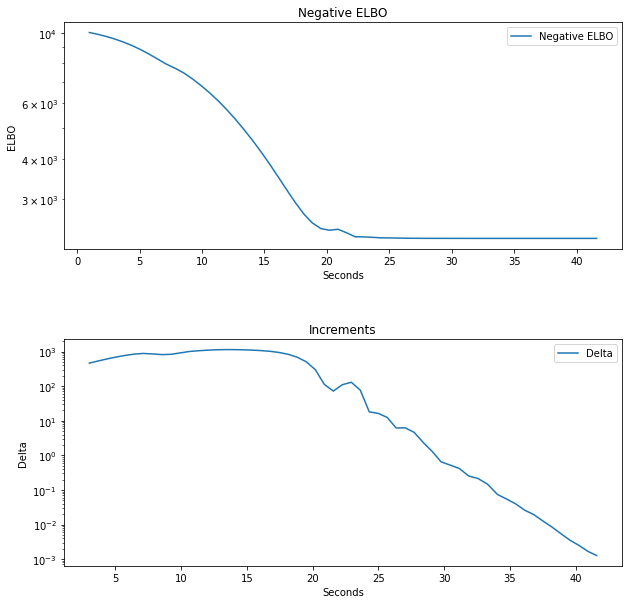

The heatmap only displays Sigma[:400,:400]


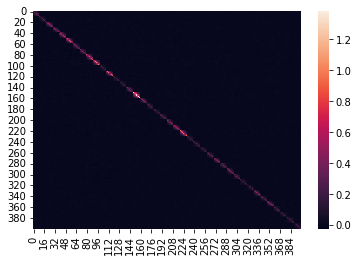


Initialization ...
Initialization finished
Maximum number of iterations reached :  15000 last delta =  4.4485743728728266e-05
Fastpca
Last ELBO : -3152.8527878300238
Dimension of the latent space : 10


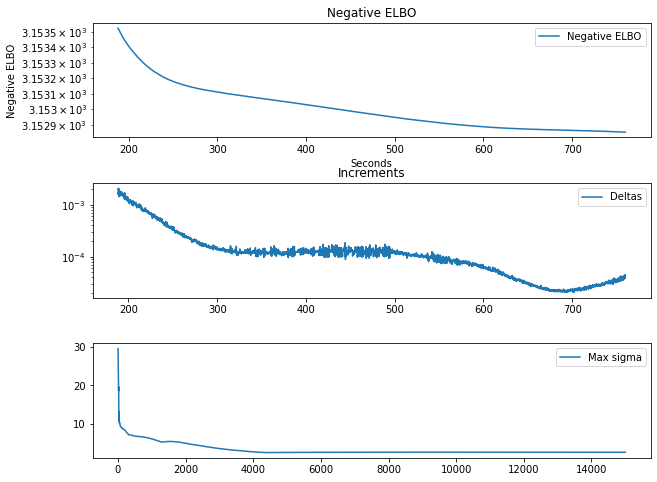

The heatmap only displays Sigma[:400,:400]


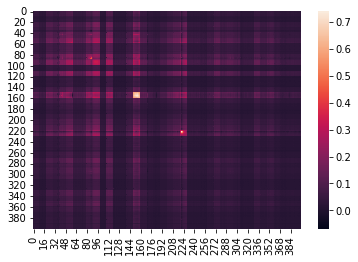

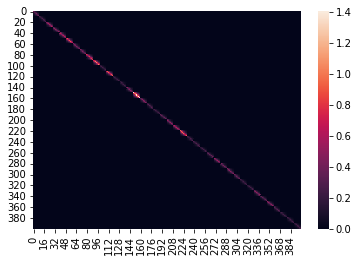

n :  28241
Initialization ...
Initialization finished
Iteration number:  0
-------UPDATE-------
Delta :  0
Iteration number:  10
-------UPDATE-------
Delta :  809.7088713018302
Iteration number:  20
-------UPDATE-------
Delta :  885.2129311101266
Iteration number:  30
-------UPDATE-------
Delta :  30.506791691368562
Iteration number:  40
-------UPDATE-------
Delta :  1.3325993169073627
Iteration number:  50
-------UPDATE-------
Delta :  0.028602500817214604
Maximum number of iterations reached :  60 last delta =  0.0009795911500987131
Fast
Last ELBO : 2219.0851852470037


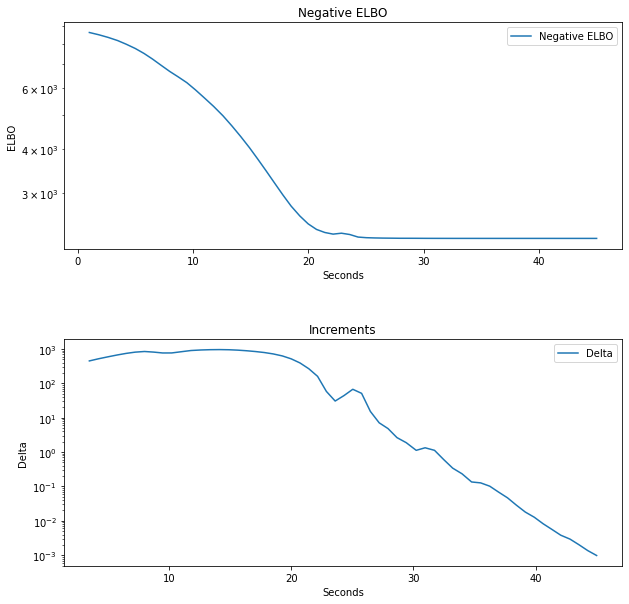

The heatmap only displays Sigma[:400,:400]


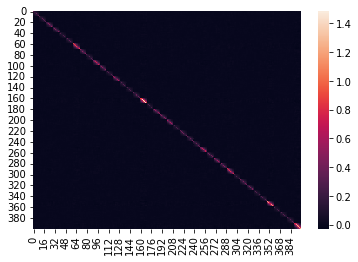


Initialization ...
Initialization finished
Maximum number of iterations reached :  15000 last delta =  1.6495414456585422e-07
Fastpca
Last ELBO : -2921.4291840027686
Dimension of the latent space : 10


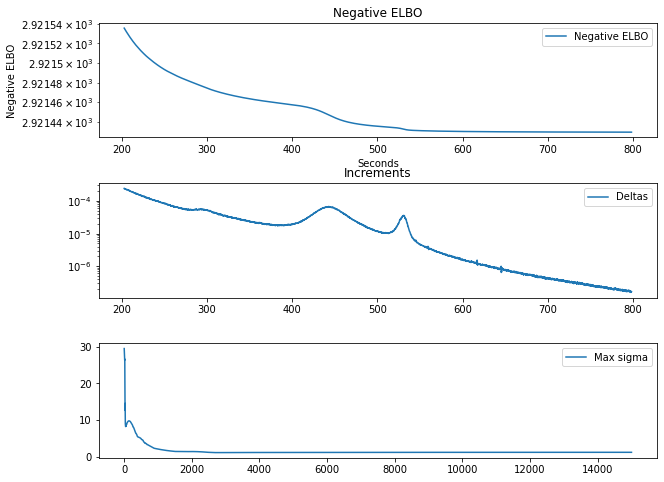

The heatmap only displays Sigma[:400,:400]


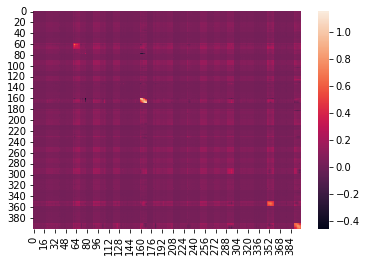

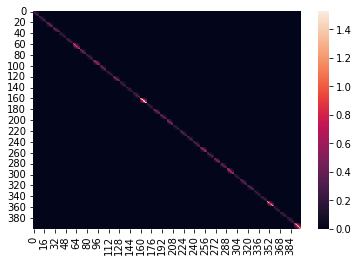

n :  30000
Initialization ...
Initialization finished
Iteration number:  0
-------UPDATE-------
Delta :  0
Iteration number:  10
-------UPDATE-------
Delta :  864.3934581482008
Iteration number:  20
-------UPDATE-------
Delta :  1196.3041852608003
Iteration number:  30
-------UPDATE-------
Delta :  75.33120121669754
Iteration number:  40
-------UPDATE-------
Delta :  1.6833986865499355
Iteration number:  50
-------UPDATE-------
Delta :  0.08702786351841496
Maximum number of iterations reached :  60 last delta =  0.005501364696101518
Fast
Last ELBO : 2231.433808915291


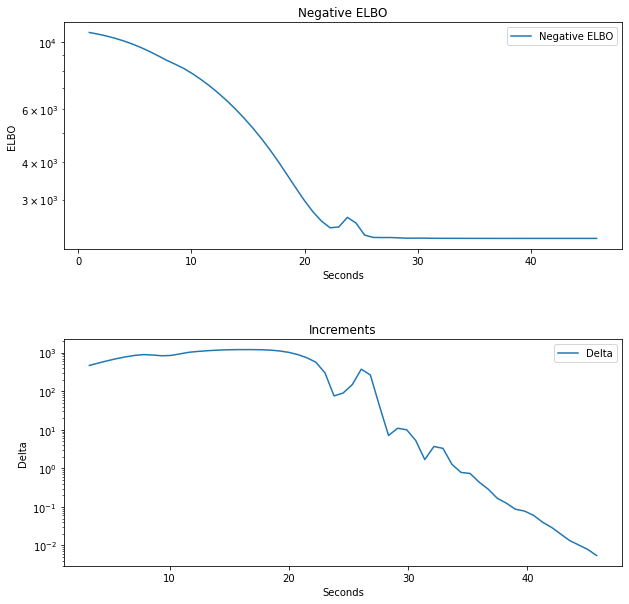

The heatmap only displays Sigma[:400,:400]


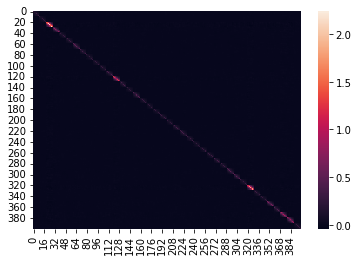


Initialization ...
Initialization finished
Maximum number of iterations reached :  15000 last delta =  6.475051122833975e-06
Fastpca
Last ELBO : -3064.1518650403045
Dimension of the latent space : 10


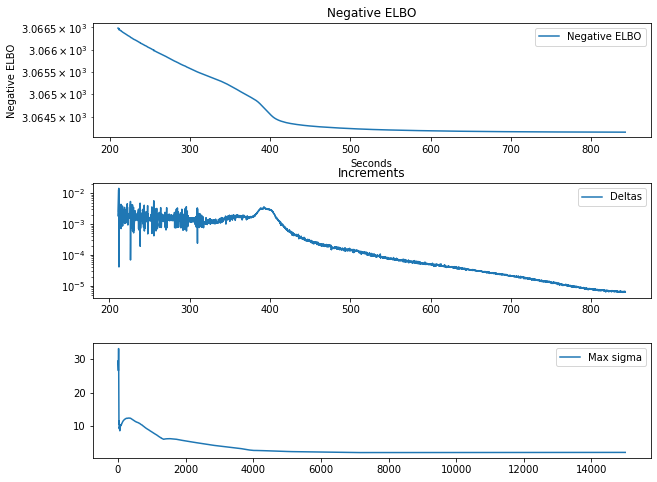

The heatmap only displays Sigma[:400,:400]


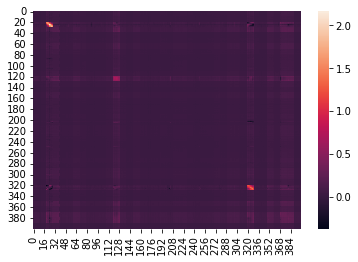

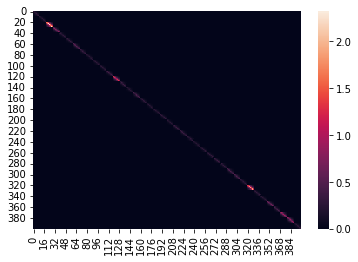

In [8]:
#n = 1000
d = 1
p = 1000
q = 10 
ns = np.linspace(100, 30000, 18).astype(int)
print('ns :', ns)

list_times_fastpca = []
list_times_fast = []


for n in ns: 
    #torch.manual_seed(0)
    print('n : ', n)
    Sigma_sampling = 1*torch.from_numpy(build_block_Sigma(p,q))/4 #+ 0.5*torch.eye(p)
    #true_C = torch.from_numpy(C_from_Sigma(Sigma_sampling, q))
    #true_Sigma_sampling = true_C@(true_C.T)
    Sigma_sampling.to(device)
    true_beta =torch.randn((d, p), device = device )*0.75

    covariates = torch.randn((n,d), device = device)/1
    O =  1+torch.zeros((n,p), device = device)
    Y, Z,_  = sample_PLN(Sigma_sampling,true_beta, O, covariates)
    Y = pd.DataFrame(Y.cpu().numpy())
    covariates = pd.DataFrame(covariates.cpu().numpy())
    O = pd.DataFrame(O.cpu().numpy())
    
    
    fast = fastPLN()
    fast.fit(Y,O,covariates, good_init = False, verbose = True, lr = 0.01, N_iter_max = 60, tol = 0)
    print('Fast')
    print(fast)
    list_times_fast.append(fast.running_times[-1])
    
    fastpca = fastPLNPCA(q)
    fastpca.fit(Y,O,covariates, good_init = False, verbose = False, lr = 0.01, N_iter_max = 15000, tol = 0)
    print('Fastpca')
    print(fastpca)
    list_times_fastpca.append(fastpca.running_times[-1])
    
    

    
    sns.heatmap(Sigma_sampling[:400,:400])
    plt.show()
    
    

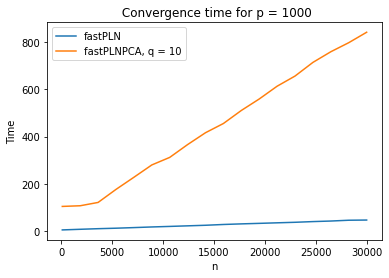

In [13]:
plt.plot(ns, list_times_fast, label = 'fastPLN')
plt.plot(ns, list_times_fastpca, label = 'fastPLNPCA, q = 10')
plt.xlabel('n')
plt.ylabel('Time')
plt.title(' Convergence time for p = 1000')
plt.legend()
#plt.savefig('Comparison_fastPLN_vs_fastPLNPCA_p=1000')

In [74]:
from fastPLNmodels.models import log_likelihood
from fastPLNmodels.utils import C_from_Sigma

new_C = C_from_Sigma(model.Sigma, p).detach()
print('log likelihood:', log_likelihood(Y,O,covariates, new_C, model.beta.detach()))

Intialization ...
Initalization done
log likelihood: tensor(-6.1016)
